<a href="https://colab.research.google.com/github/mikkeljais/sds_tddl_2020/blob/master/ex9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Exercise 9.1 & 9.2
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# load dataset
path2tox_data = '/content/drive/My Drive/Colab Notebooks/train.csv'
tox_df = pd.read_csv(path2tox_data)

tox_df['label'] = (tox_df.target>0.5).astype(int)

strat_sample_cols = list(tox_df.columns[3:23])+['physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']
samples = []
n = 500
for col in strat_sample_cols:
    binary = pd.DataFrame((tox_df[col]>0.5).astype(int))
    samples+=[j for _,j in binary.groupby(col).apply(lambda x: x.sample(min(len(x),n//2))).index]
idx = list(set(samples))
df = tox_df.iloc[idx].copy()

sample = df.groupby('label').apply(lambda x: x.sample(500))
sample_texts = sample.comment_text.values
print(df.shape,tox_df.shape)

test_df = pd.read_csv('/content/drive/My Drive/test.csv')



(11113, 46) (1804874, 46)


In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tox_df['comment_text'], 
                                                    tox_df['label'], 
                                                    test_size=0.3, 
                                                    stratify=np.array(tox_df['label']), 
                                                    random_state=42)

val_dat = (np.array([i for i in x_test.values]), y_test.values)

In [89]:
#defining the basemodel

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
basetfmodel = tf.keras.models.Sequential()
basetfmodel.add(hub.KerasLayer(embed, input_shape=[], dtype=tf.string, trainable=False))
#Training is performed on the toxicity data, but only on the comment text
basetfmodel.compile(optimizer=tf.keras.optimizers.Adam('adam', {'Dense': 0.5, 'Output': 1.5}),  loss='sparse_categorical_crossentropy')
basetfmodel.fit(x_train, epochs=5, batch_size=None) #validation_data=(x_test, y_test), validation_data_batch_size=50000)

Epoch 1/5
39482/39482 [==============================] - 35s 876us/step - loss: 0.0000e+00
Epoch 2/5
39482/39482 [==============================] - 35s 878us/step - loss: 0.0000e+00
Epoch 3/5
39482/39482 [==============================] - 35s 890us/step - loss: 0.0000e+00
Epoch 4/5
39482/39482 [==============================] - 35s 894us/step - loss: 0.0000e+00
Epoch 5/5
39482/39482 [==============================] - 36s 911us/step - loss: 0.0000e+00


In [0]:
#9.1.2
## using sklearn for splitting the dataset in train and validation set

from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

train, val = train_test_split(tox_df,test_size = 0.05, random_state = 23)



In [0]:
## these are the identity columns or minorities if you will 

identity_columns = ['asian', 'atheist',
       'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'jewish', 'latino', 'male',
       'muslim','psychiatric_or_mental_illness', 'transgender', 'white']

y_identities_train = (train[identity_columns] >= 0.5).astype(int).values
y_identities_val = (val[identity_columns] >= 0.5).astype(int).values

In [0]:
for column in identity_columns + ['target']:
    df[column] = np.where(df[column] >= 0.5, True, False)


In [0]:
# Target variable as well
y = tox_df['target'].values

In [0]:
#vectorizing the words
train_df, cv_df, y_train, y_cv = train_test_split(tox_df, y, test_size=0.2, random_state=42)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [0]:
train_tfidf = vectorizer.fit_transform(train_df["comment_text"])
cv_tfidf = vectorizer.transform(cv_df["comment_text"])
test_tfidf = vectorizer.transform(test_df["comment_text"])

In [0]:
#defining the confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    tox_df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(tox_df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [0]:
#setting a threshold
def threshold_based_prediction(proba,threshold,tpr,fpr):
    thres = threshold[np.argmax(fpr*(1-tpr))]
    predictions = []
    for i in proba:
        if i>=thres:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
#Using TFIDF to vectorize the data
alpha = [10 ** x for x in range(-5, 2)]
auc_array_train=[]
auc_array_cv=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=5,class_weight='balanced')
  clf.fit(train_tfidf, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(train_tfidf, y_train)
    
    
  predict_y_train = sig_clf.predict_proba(train_tfidf)[:,1]
  predict_y = sig_clf.predict_proba(cv_tfidf)[:,1]
  auc_array_train.append(roc_auc_score(y_train, predict_y_train))
  auc_array_cv.append(roc_auc_score(y_cv, predict_y))

In [0]:
#defining false positive rate and true positive rate etc.
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_cv, predict_y)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


In [16]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, y_train)



CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                     

	Toxic Train data confusion matrix


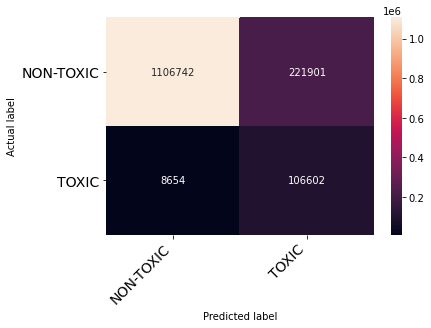

In [21]:
predtrain = sig_clf.predict_proba(train_tfidf)[:,1]
predcv = sig_clf.predict_proba(cv_tfidf)[:,1]
pred = sig_clf.predict_proba(test_tfidf)[:,1]
predtrain = threshold_based_prediction(predtrain,threshold_train,tpr_train,fpr_train)
cm = confusion_matrix(y_train, predtrain)
print("\tToxic Train data confusion matrix")
print_confusion_matrix(cm,class_names=['NON-TOXIC','TOXIC'])

So from the confusion matrix it is visible that of the overall comment-texts 1106742 non-toxic comments are being correctly classified as non-toxic comments, i.e. around 80% are true positives (correctly classified as non-toxic). It is also seen that 106602 comment-texts are true negatives, i.e. 106602 toxic comments are being correctly classified as being toxic out of a total of 115256 toxic comments. This means that the accuracy to which the true negatives is classified amounts to around 92%. In conclusion it can be said, that the model is better at classifying toxic comment correctly compared to classification of non-toxic comments. So there is more classification error for the non-toxic comments than the toxic comments.

In [25]:
print(classification_report(y_cv,predcv.round()))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97    331897
        True       0.79      0.38      0.51     29078

    accuracy                           0.94    360975
   macro avg       0.87      0.68      0.74    360975
weighted avg       0.93      0.94      0.93    360975



It can be concluded that the model is slightly overfitting on the toxic-train data. The model is not doing a particularly good job against the unintended bias which we seek to avoid.
From the F1 score we can see that the model does a better job in correctly classifying the toxic-comments as being toxic, compared with correctly classifying non-toxic comments as being non-toxic.



In [0]:
#exercise 9.3
